# Comparison of GNN results with REF15

1. Compare results of best model from hyperparameter tuning with REF15 for AbAg-affinity test set and AB-benchmark

2. Check how robust GNN ist on 4-Fold Cross Validation

In [84]:
import pandas as pd
import os
from collections import defaultdict
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from abag_affinity.utils.config import read_config, get_data_paths
from pathlib import Path
from scipy.stats import norm
import seaborn as sns

In [85]:
project_root = "../../"# "." #"../.."
plot_path = os.path.join(project_root, "results", "experiments", "GNN_REF15_comparison_cv")
Path(plot_path).mkdir(exist_ok=True, parents=True)

col_mapping = {
    "prediction": "gnn_prediction",
    "labels": "-log(Kd)_labels"
}

gnn_abag_test_result_path = os.path.join(project_root, "results/predictions/CV_experiment/abag_affinity_test_cv{}.csv")
gnn_ab_benchmark_result_path = os.path.join(project_root, "results/predictions/CV_experiment/benchmark_cv{}.csv")


In [86]:
num_splits = 10

gnn_cv_results = {}
split_pdbs = {}

for i in range(1, num_splits + 1):
    gnn_cv_results[i] = {}
    
    gnn_cv_results[i]["abag_validation"] = pd.read_csv(gnn_abag_test_result_path.format(str(i)), index_col=0).set_index("pdb").rename(col_mapping, axis=1)
    split_pdbs[i] = gnn_cv_results[i]["abag_validation"].index.values.tolist()
    
    gnn_cv_results[i]["benchmark"] = pd.read_csv(gnn_ab_benchmark_result_path.format(str(i)), index_col=0).set_index("pdb").rename(col_mapping, axis=1)

In [132]:
from sklearn.metrics import mean_squared_error
all_gnn_predictions = []
all_labels = []

all_gnn_rmse = []
all_gnn_pearson_r = []

errors = []

for i in range(1, num_splits + 1):
    predictions = gnn_cv_results[i]["abag_validation"]["gnn_prediction"].tolist()
    labels = gnn_cv_results[i]["abag_validation"]["-log(Kd)_labels"].tolist()
    
    all_gnn_predictions.extend(predictions)
    all_labels.extend(labels)

    val_rmse = mean_squared_error(labels, predictions, squared=False)
    val_pearson = stats.pearsonr(labels, predictions)[0]

    errors.append(np.abs(np.array(predictions) - np.array(labels)))

    all_gnn_rmse.append(val_rmse)
    all_gnn_pearson_r.append(val_pearson)
    print(f"Split {i}: RMSE={round(val_rmse, 3)}, R={round(val_pearson,3)}")

val_rmse = mean_squared_error(all_labels, all_gnn_predictions)
val_pearson = stats.pearsonr(all_labels, all_gnn_predictions)[0]
print(f"\nFull dataset: RMSE={round(val_rmse, 3)}, R={round(val_pearson,3)}")

Split 1: RMSE=1.433, R=0.324
Split 2: RMSE=1.529, R=0.395
Split 3: RMSE=1.265, R=0.431
Split 4: RMSE=0.957, R=0.345
Split 5: RMSE=1.308, R=0.351
Split 6: RMSE=1.435, R=0.203
Split 7: RMSE=1.646, R=0.377
Split 8: RMSE=0.907, R=0.572
Split 9: RMSE=1.455, R=0.442
Split 10: RMSE=1.379, R=0.064

Full dataset: RMSE=1.824, R=0.367


In [88]:
config = read_config(os.path.join(project_root, "src", "config.yaml"))
force_field_results_folder = config["force_field_results"]
assumed_temp = 298.15
gas_constant = 8.31446261815324

def get_scores(path):
    # get pdb_ids
    with open(os.path.join(path, "data_points.txt")) as f:
        pdbs = f.readlines()
    pdbs = [ pdb.split(",")[0].strip().lower() for pdb in pdbs]

    # get delta g scores
    with open(os.path.join(path, "results.txt")) as f:
        scores = f.readlines()

    results = defaultdict(dict)
    pdb_idx = 0
    for score in scores:
        if score == 'Antibody\n':
            score_type = "Antibody"
        if score == 'Antigen\n':
            score_type = "Antigen"
        if score == 'Complex\n':
            score_type = "Complex"
        if score in ["\n", 'Antibody\n', 'Antigen\n', 'Complex\n', 'fa_atr\n', 'score\n']:
            pdb_idx = 0
            continue
            
        results[pdbs[pdb_idx]][score_type] = score.strip()
        pdb_idx += 1

    rosetta_scores = pd.DataFrame(results.values())
    rosetta_scores.index = results.keys()
    rosetta_scores = rosetta_scores.astype(float)
    rosetta_scores["rosetta_delta_g"] = rosetta_scores["Complex"] - rosetta_scores["Antibody"] - rosetta_scores["Antigen"]
    
    return rosetta_scores

In [89]:
benchmark_ref15_scores = get_scores(os.path.join(force_field_results_folder, "guest_REF15", "antibody_benchmark"))

abag_rosetta_scores = get_scores(os.path.join(force_field_results_folder, "guest_REF15", "abag_affinity_dataset"))

abag_summary_path = os.path.join(config["DATASETS"]["path"], config["DATASETS"]["abag_affinity"]["folder_path"], config["DATASETS"]["abag_affinity"]["summary"])
full_abag_df = pd.read_csv(abag_summary_path, index_col=0)

In [90]:
abag_preds_and_labels = abag_rosetta_scores.join(full_abag_df)
abag_preds_and_labels = abag_preds_and_labels[~abag_preds_and_labels["delta_g"].isna()]

In [91]:
def reject_outliers(data):
 u = np.mean(data["rosetta_delta_g"])
 s = np.std(data["rosetta_delta_g"])
 data_filtered = data[(data["rosetta_delta_g"]>(u-1*s)) & (data["rosetta_delta_g"]<(u+1*s))]
 return data_filtered

In [92]:
delta_g_max = full_abag_df["delta_g"].max()
delta_g_min = full_abag_df["delta_g"].min()

abag_rosetta_scores_wo_outliers = reject_outliers(abag_rosetta_scores)
max = abag_rosetta_scores_wo_outliers["rosetta_delta_g"].max()
min = abag_rosetta_scores_wo_outliers["rosetta_delta_g"].min()


def calc_kd(delta_g, estimator):
    #delta_g = estimator.predict(np.array(delta_g).reshape(1,-1)).item() # scale value

    # sclae values
    #max = -16
    #min = -38

    delta_g = max if delta_g > max else delta_g
    delta_g = min if delta_g < min else delta_g

    OldRange = (max - min)
    NewRange = (delta_g_max - delta_g_min)
    delta_g = (((delta_g - min) * NewRange) / OldRange) + delta_g_min

    delta_g = delta_g * 4184 # convert to cal

    kd = 1 / np.exp(-delta_g / ( gas_constant * assumed_temp))
    return kd


In [93]:
from sklearn.linear_model import LinearRegression

ref15_cv_results = {}

for i in range(1, num_splits + 1):
    ref15_cv_results[i] = {}
    
    train_data = abag_preds_and_labels[~abag_preds_and_labels.index.isin(split_pdbs[i])]
    train_data = reject_outliers(train_data)
    X = train_data["rosetta_delta_g"].values.reshape(-1, 1)
    y = train_data["delta_g"].values.reshape(-1, 1)
    rosetta_fit = LinearRegression().fit(X, y)

    ref15_cv_results[i]["abag_validation"] = abag_rosetta_scores.loc[split_pdbs[i]]   
    ref15_cv_results[i]["abag_validation"]["ref15_kd_prediction"] = ref15_cv_results[i]["abag_validation"]["rosetta_delta_g"].apply(lambda x: calc_kd(x, rosetta_fit)) 
    ref15_cv_results[i]["abag_validation"]["ref15_prediction"] = ref15_cv_results[i]["abag_validation"]["ref15_kd_prediction"].apply(lambda x: -np.log10(x)) 
    
    ref15_cv_results[i]["benchmark"] = benchmark_ref15_scores
    ref15_cv_results[i]["benchmark"]["ref15_kd_prediction"] = ref15_cv_results[i]["benchmark"]["rosetta_delta_g"].apply(lambda x: calc_kd(x, rosetta_fit)) 
    ref15_cv_results[i]["benchmark"]["ref15_prediction"] = ref15_cv_results[i]["benchmark"]["ref15_kd_prediction"].apply(lambda x: -np.log10(x)) 


In [94]:
all_ref15_predictions = []
all_ref15_rsme = []
all_ref15_pearson_r = []

for i in range(1, num_splits + 1):
    predictions = ref15_cv_results[i]["abag_validation"]["ref15_prediction"].tolist()
    labels = gnn_cv_results[i]["abag_validation"]["-log(Kd)_labels"].tolist()

    all_ref15_predictions.extend(predictions)

    val_rmse = mean_squared_error(labels, predictions)
    val_pearson = stats.pearsonr(labels, predictions)[0]

    all_ref15_rsme.append(val_rmse)
    all_ref15_pearson_r.append(val_pearson)

    print(f"Split {i}: RMSE={round(val_rmse, 3)}, R={round(val_pearson,3)}")
    
val_rmse = mean_squared_error(all_labels, all_ref15_predictions)
val_pearson = stats.pearsonr(all_labels, all_ref15_predictions)[0]
print(f"\nFull dataset: RMSE={round(val_rmse, 3)}, R={round(val_pearson,3)}")

Split 1: RMSE=3.641, R=-0.054
Split 2: RMSE=4.355, R=0.032
Split 3: RMSE=2.502, R=0.138
Split 4: RMSE=1.994, R=-0.08
Split 5: RMSE=2.095, R=0.352
Split 6: RMSE=3.544, R=0.155
Split 7: RMSE=4.614, R=0.082
Split 8: RMSE=1.588, R=0.183
Split 9: RMSE=3.147, R=0.129
Split 10: RMSE=3.63, R=0.232

Full dataset: RMSE=3.118, R=0.11


## Absolute Error Comparison

In [95]:
abag_resuts_df = pd.DataFrame({"-log(Kd)_labels": all_labels, "gnn_prediction": all_gnn_predictions, "ref15_prediction": all_ref15_predictions})

In [96]:
abag_resuts_df["gnn_diff"] = abag_resuts_df["gnn_prediction"] - abag_resuts_df["-log(Kd)_labels"]
abag_resuts_df["gnn_error"] = np.abs(abag_resuts_df["gnn_diff"])

In [97]:
abag_resuts_df["ref15_diff"] = abag_resuts_df["ref15_prediction"] - abag_resuts_df["-log(Kd)_labels"]
abag_resuts_df["ref15_error"] = np.abs(abag_resuts_df["ref15_diff"])

In [98]:
abag_resuts_df["error_diff"] = abag_resuts_df["gnn_error"] - abag_resuts_df["ref15_error"]

abag_resuts_df.describe()

,-log(Kd)_labels,gnn_prediction,ref15_prediction,gnn_diff,gnn_error,ref15_diff,ref15_error,error_diff
count,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000
mean,8.165188,8.131629,8.140757,-0.033559,1.035766,-0.024431,1.391194,-0.355429
std,1.450574,0.611048,1.183408,1.351819,0.867720,1.767873,1.088812,1.028167
min,3.795880,6.253500,3.795872,-4.070697,0.002546,-5.843992,0.000128,-4.765736
25%,7.193820,7.833443,7.813164,-0.897323,0.320635,-1.143553,0.505695,-0.799243
50%,8.102373,8.262432,8.416666,0.034326,0.822716,0.215192,1.199699,-0.228382
75%,9.094204,8.563451,8.811196,0.771324,1.514744,1.201439,1.971274,0.259065
max,11.769551,9.919485,11.769526,4.854628,4.854628,4.401227,5.843992,2.255778


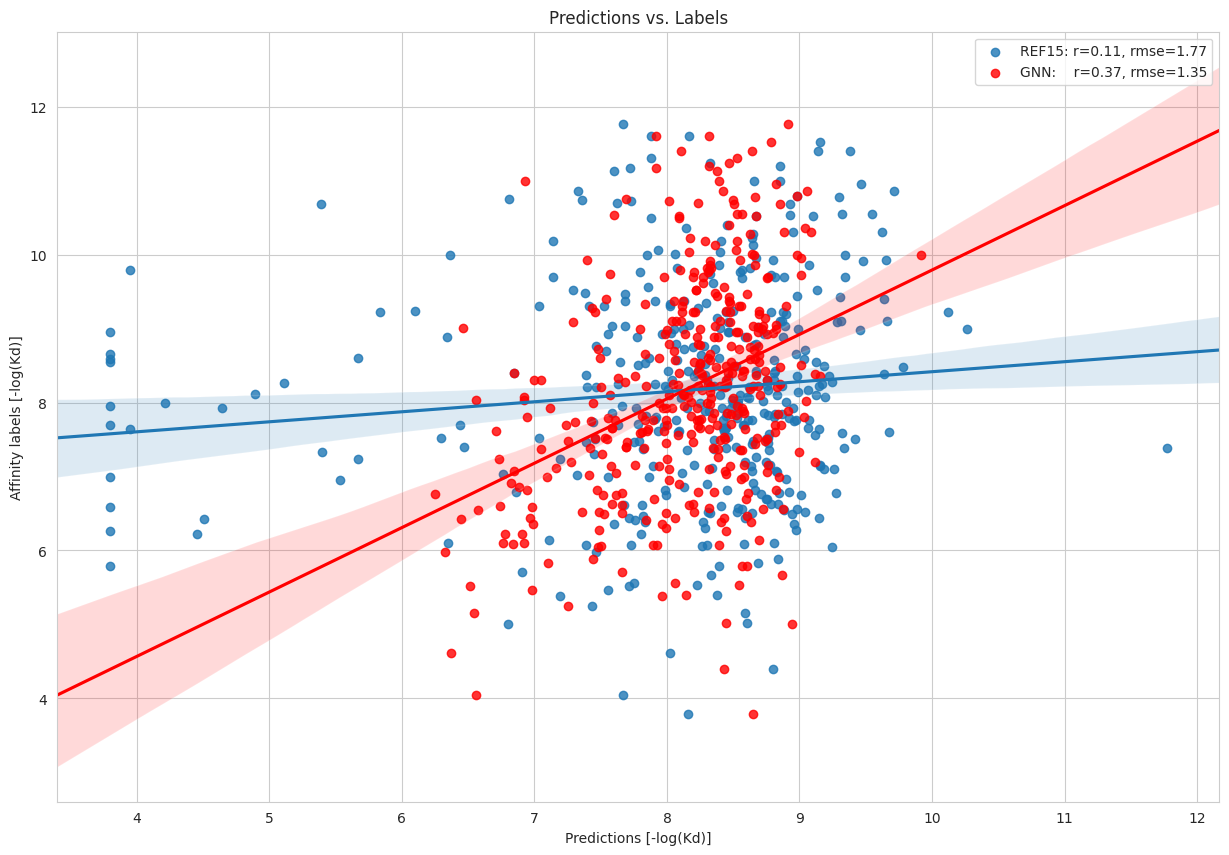

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

#ax.set_xlim(np.min((abag_resuts_df["ref15_prediction"].min(), abag_resuts_df["gnn_prediction"].min())), 
#         np.max((abag_resuts_df["ref15_prediction"].max(), abag_resuts_df["gnn_prediction"].max())))


legend = "REF15: "
r, p = stats.pearsonr(x=abag_resuts_df["ref15_prediction"].values, y=abag_resuts_df["-log(Kd)_labels"].values)
legend += 'r={:.2f}, '.format(r)
error = np.sqrt(np.mean((abag_resuts_df["ref15_prediction"].values-abag_resuts_df["-log(Kd)_labels"].values)**2))
legend += 'rmse={:.2f}'.format(error)

sns.regplot(data=abag_resuts_df, x="ref15_prediction",y="-log(Kd)_labels", ax=ax, truncate=False, label=legend)


legend = "GNN:    "
r, p = stats.pearsonr(x=abag_resuts_df["gnn_prediction"].values, y=abag_resuts_df["-log(Kd)_labels"].values)
legend += 'r={:.2f}, '.format(r)
error = np.sqrt(np.mean((abag_resuts_df["gnn_prediction"].values-abag_resuts_df["-log(Kd)_labels"].values)**2))
legend += 'rmse={:.2f}'.format(error)
sns.regplot(data=abag_resuts_df, x="gnn_prediction", y="-log(Kd)_labels", ax=ax, color="red", truncate=False, label=legend)

ax.set_title("Predictions vs. Labels")
ax.set_xlabel("Predictions [-log(Kd)]")
ax.set_ylabel("Affinity labels [-log(Kd)]")

ax.legend()

plt.savefig(os.path.join(plot_path, "abag_full_comparison_scatter.png"))
plt.show()
plt.close()

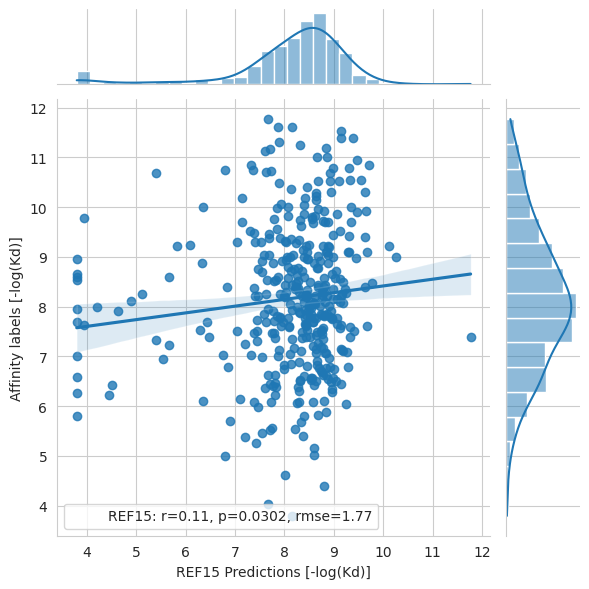

In [101]:
legend = "REF15: "
r, p = stats.pearsonr(x=abag_resuts_df["ref15_prediction"].values, y=abag_resuts_df["-log(Kd)_labels"].values)
legend += 'r={:.2f}, p={:.4f}, '.format(r, p)
error = np.sqrt(np.mean((abag_resuts_df["ref15_prediction"].values-abag_resuts_df["-log(Kd)_labels"].values)**2))
legend += 'rmse={:.2f}'.format(error)

plot = sns.jointplot(x=abag_resuts_df["ref15_prediction"].values, y=abag_resuts_df["-log(Kd)_labels"].values, kind="reg")

plot.ax_joint.set_xlabel("REF15 Predictions [-log(Kd)]")
plot.ax_joint.set_ylabel("Affinity labels [-log(Kd)]")

phantom, = plot.ax_joint.plot([], [], linestyle="", alpha=0)
plot.ax_joint.legend([phantom], [legend])
plt.tight_layout()

plt.savefig(os.path.join(plot_path, "ref15_abag_corr_plot.png"))
plt.show()
plt.close()

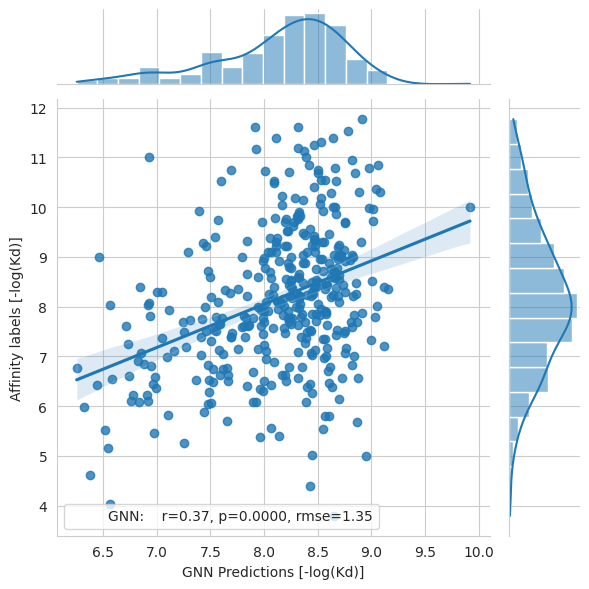

In [102]:
#ax.set_xlim(np.min((abag_resuts_df["ref15_prediction"].min(), abag_resuts_df["gnn_prediction"].min())),
#         np.max((abag_resuts_df["ref15_prediction"].max(), abag_resuts_df["gnn_prediction"].max())))

legend = "GNN:    "
r, p = stats.pearsonr(x=abag_resuts_df["gnn_prediction"].values, y=abag_resuts_df["-log(Kd)_labels"].values)
legend += 'r={:.2f}, p={:.4f}, '.format(r, p)
error = np.sqrt(np.mean((abag_resuts_df["gnn_prediction"].values-abag_resuts_df["-log(Kd)_labels"].values)**2))
legend += 'rmse={:.2f}'.format(error)
plot = sns.jointplot(x=abag_resuts_df["gnn_prediction"].values, y=abag_resuts_df["-log(Kd)_labels"].values, kind="reg")

plot.ax_joint.set_xlabel("GNN Predictions [-log(Kd)]")
plot.ax_joint.set_ylabel("Affinity labels [-log(Kd)]")

phantom, = plot.ax_joint.plot([], [], linestyle="", alpha=0)
plot.ax_joint.legend([phantom], [legend])
plt.tight_layout()
plt.savefig(os.path.join(plot_path, "gnn_abag_corr_plot.png"))
plt.show()
plt.close()

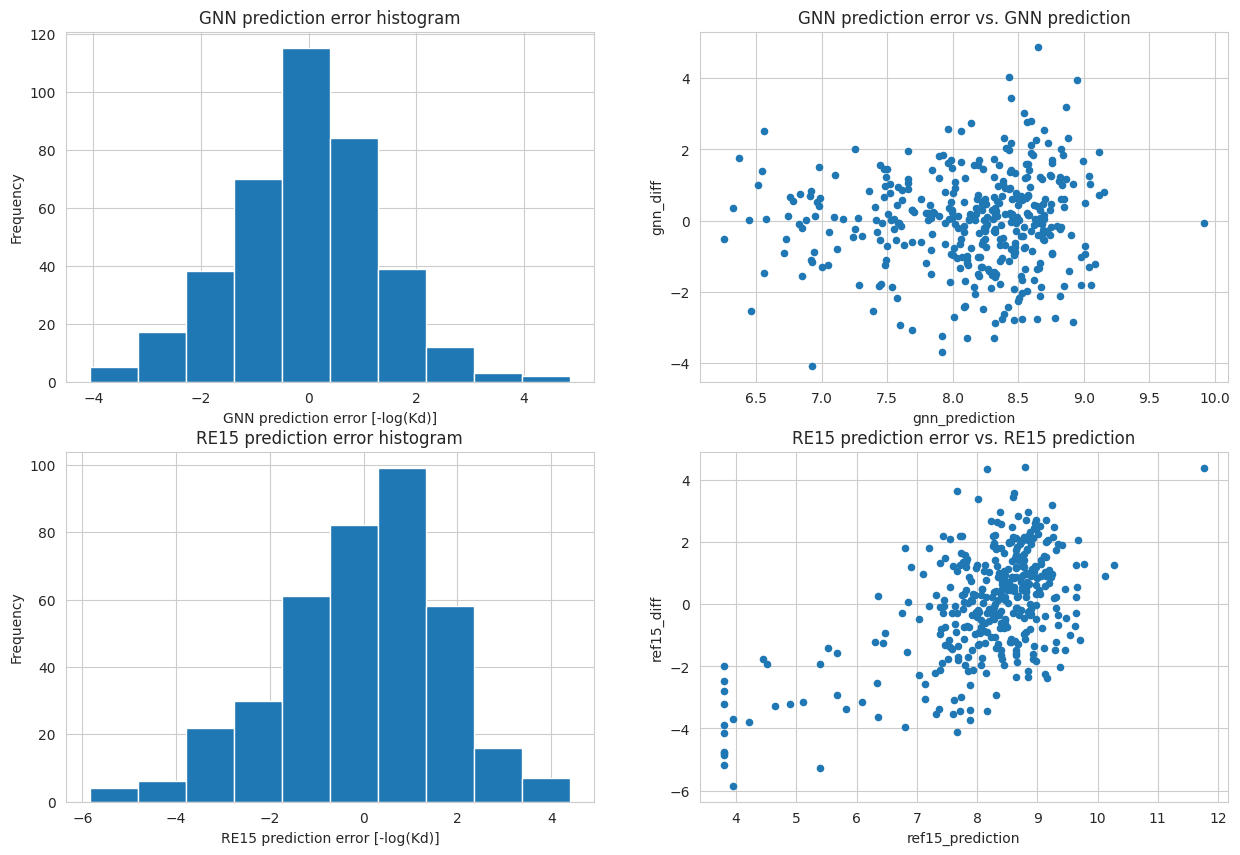

In [103]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

abag_resuts_df["gnn_diff"].plot.hist(ax=ax[0,0])
ax[0,0].set_title("GNN prediction error histogram")
ax[0,0].set_xlabel("GNN prediction error [-log(Kd)]")

abag_resuts_df.plot.scatter("gnn_prediction", "gnn_diff", ax=ax[0,1])
ax[0,1].set_title("GNN prediction error vs. GNN prediction")

abag_resuts_df["ref15_diff"].plot.hist(ax=ax[1,0])
ax[1,0].set_title("RE15 prediction error histogram")
ax[1,0].set_xlabel("RE15 prediction error [-log(Kd)]")

abag_resuts_df[abag_resuts_df["ref15_prediction"] > 0].plot.scatter("ref15_prediction", "ref15_diff", ax=ax[1,1])
ax[1,1].set_title("RE15 prediction error vs. RE15 prediction")

plt.savefig(os.path.join(plot_path, "abag_error_distributions.png"))
plt.show()
plt.close()

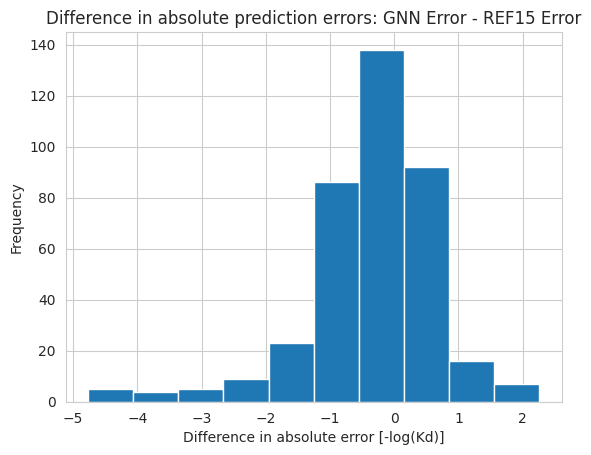

In [104]:
abag_resuts_df["error_diff"].plot.hist()
plt.title("Difference in absolute prediction errors: GNN Error - REF15 Error")
plt.xlabel("Difference in absolute error [-log(Kd)]")
plt.savefig(os.path.join(plot_path, "abag_error_difference_distributions.png"))
plt.show()
plt.close()

In [105]:
stats.wilcoxon(abag_resuts_df["gnn_error"], abag_resuts_df["ref15_error"], alternative="less")

WilcoxonResult(statistic=23606.0, pvalue=2.825764401440589e-10)

In [134]:
abag_resuts_df["gnn_error"].describe()

count    385.000000
mean       1.035766
std        0.867720
min        0.002546
25%        0.320635
50%        0.822716
75%        1.514744
max        4.854628
Name: gnn_error, dtype: float64

In [135]:
abag_resuts_df["ref15_error"].describe()

count    385.000000
mean       1.391194
std        1.088812
min        0.000128
25%        0.505695
50%        1.199699
75%        1.971274
max        5.843992
Name: ref15_error, dtype: float64

## RSME Comparison

In [106]:
abag_resulst_cv = pd.DataFrame({"gnn_rmse":all_gnn_rmse, "ref15_rmse": all_ref15_rsme, "gnn_pearson": all_gnn_pearson_r, "ref15_pearson": all_ref15_pearson_r})
abag_resulst_cv["rmse_diff"] = abag_resulst_cv["gnn_rmse"] - abag_resulst_cv["ref15_rmse"]
abag_resulst_cv["pearson_diff"] = abag_resulst_cv["gnn_pearson"] - abag_resulst_cv["ref15_pearson"]

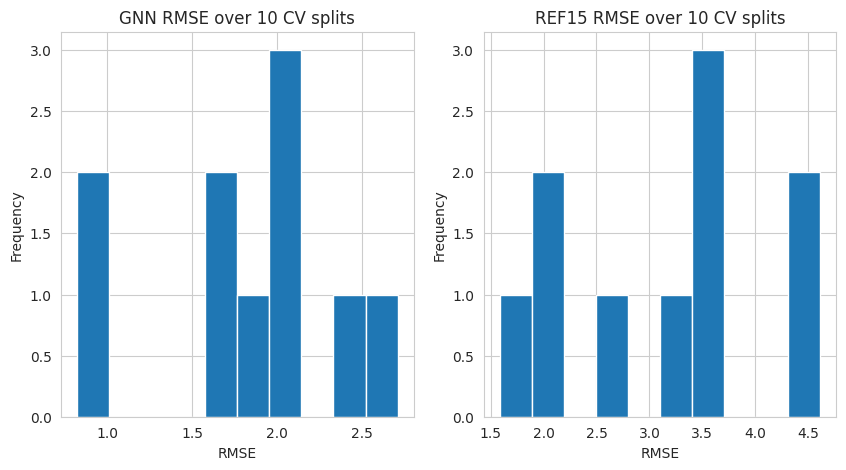

In [107]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

abag_resulst_cv["gnn_rmse"].plot.hist(ax=ax[0])
ax[0].set_title("GNN RMSE over 10 CV splits")
ax[0].set_xlabel("RMSE")

abag_resulst_cv["ref15_rmse"].plot.hist(ax=ax[1])
ax[1].set_title("REF15 RMSE over 10 CV splits")
ax[1].set_xlabel("RMSE")


plt.savefig(os.path.join(plot_path, "RMSE_CV_comparison.png"))
plt.show()
plt.close()

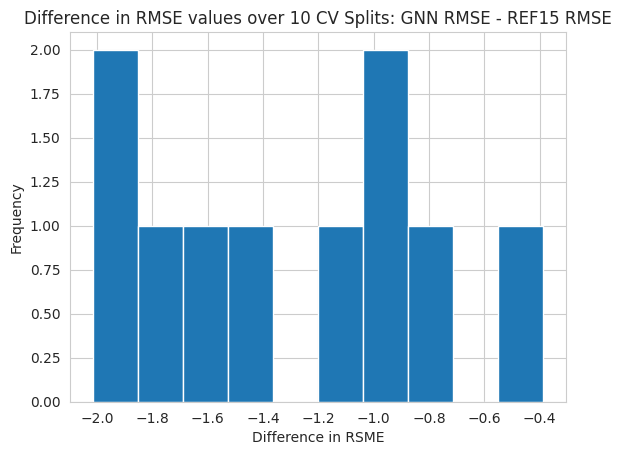

In [108]:
abag_resulst_cv["rmse_diff"].plot.hist()
plt.title("Difference in RMSE values over 10 CV Splits: GNN RMSE - REF15 RMSE")
plt.xlabel("Difference in RSME")
plt.savefig(os.path.join(plot_path, "abag_rsme_difference_distributions.png"))
plt.show()
plt.close()

In [109]:
stats.wilcoxon(abag_resulst_cv["gnn_rmse"], abag_resulst_cv["ref15_rmse"], alternative="less")

WilcoxonResult(statistic=0.0, pvalue=0.0009765625)

In [127]:
abag_resulst_cv["gnn_rmse"].describe()

count    10.000000
mean      1.822780
std       0.590646
min       0.821998
25%       1.627330
50%       1.976955
75%       2.103735
max       2.709283
Name: gnn_rmse, dtype: float64

In [128]:
abag_resulst_cv["ref15_rmse"].describe()

count    10.000000
mean      3.111117
std       1.028173
min       1.588441
25%       2.197119
50%       3.345727
75%       3.637886
max       4.614130
Name: ref15_rmse, dtype: float64

## Pearson Correlation Comparison

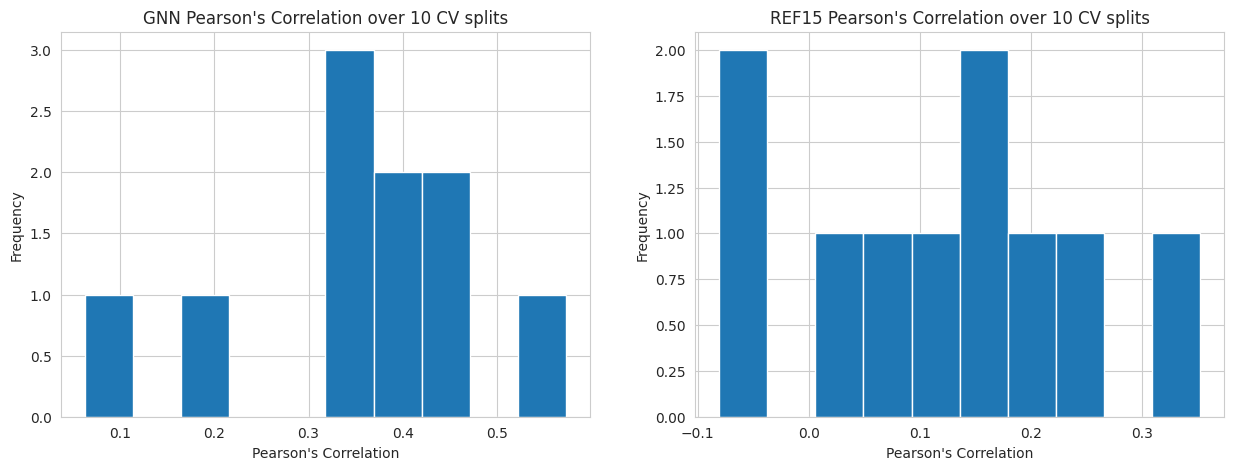

In [110]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

abag_resulst_cv["gnn_pearson"].plot.hist(ax=ax[0])
ax[0].set_title("GNN Pearson's Correlation over 10 CV splits")
ax[0].set_xlabel("Pearson's Correlation")

abag_resulst_cv["ref15_pearson"].plot.hist(ax=ax[1])
ax[1].set_title("REF15 Pearson's Correlation over 10 CV splits")
ax[1].set_xlabel("Pearson's Correlation")


plt.savefig(os.path.join(plot_path, "Pearson_R_CV_comparison.png"))
plt.show()
plt.close()

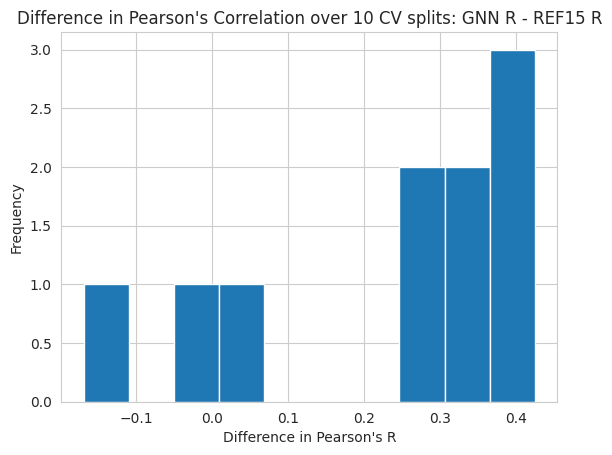

In [111]:
abag_resulst_cv["pearson_diff"].plot.hist()
plt.title("Difference in Pearson's Correlation over 10 CV splits: GNN R - REF15 R")
plt.xlabel("Difference in Pearson's R")
plt.savefig(os.path.join(plot_path, "abag_pearson_difference_distributions.png"))
plt.show()
plt.close()

In [112]:
stats.wilcoxon(abag_resulst_cv["gnn_pearson"], abag_resulst_cv["ref15_pearson"], alternative="greater")

WilcoxonResult(statistic=51.0, pvalue=0.0068359375)

In [125]:
abag_resulst_cv["gnn_pearson"].describe()

count    10.000000
mean      0.350241
std       0.138038
min       0.063595
25%       0.328944
50%       0.363781
75%       0.422219
max       0.572244
Name: gnn_pearson, dtype: float64

In [126]:
abag_resulst_cv["ref15_pearson"].describe()

count    10.000000
mean      0.116889
std       0.129668
min      -0.080453
25%       0.044526
50%       0.133579
75%       0.176044
max       0.351587
Name: ref15_pearson, dtype: float64

## AB-benchmark

In [136]:
benchmark_gnn_results = gnn_cv_results[1]["benchmark"]
all_benchmark_labels = benchmark_gnn_results["-log(Kd)_labels"]
all_benchmark_gnn_predictions = benchmark_gnn_results["gnn_prediction"]

In [137]:
benchmark_ref15_results = ref15_cv_results[1]["benchmark"]
all_benchmark_ref15_predictions = benchmark_ref15_results["ref15_prediction"]

In [138]:
gnn_benchmark_rmse = mean_squared_error(all_benchmark_labels, all_benchmark_gnn_predictions, squared=False)
gnn_benchmark_pearson, gnn_pearson_p_value = stats.pearsonr(all_benchmark_labels, all_benchmark_gnn_predictions)
gnn_benchmark_mae = np.mean(np.abs(all_benchmark_labels - all_benchmark_gnn_predictions))

In [139]:
ref15_benchmark_rmse = mean_squared_error(all_benchmark_labels, all_benchmark_ref15_predictions, squared=False)
ref15_benchmark_pearson, ref15_pearson_p_value  = stats.pearsonr(all_benchmark_labels, all_benchmark_ref15_predictions)
ref15_benchmark_mae = np.mean(np.abs(all_benchmark_labels - all_benchmark_ref15_predictions))


In [140]:
print(f"Benchmark RMSE >>> GNN={round(gnn_benchmark_rmse, 2)}, REF15={round(ref15_benchmark_rmse, 2)}")
print(f"Benchmark Pearson's R >>> GNN={round(gnn_benchmark_pearson, 2)}({gnn_pearson_p_value}), REF15={round(ref15_benchmark_pearson, 2)}({ref15_pearson_p_value})")
print(f"Benchmark MAE >>> GNN={round(gnn_benchmark_mae, 2)}, REF15={round(ref15_benchmark_mae, 2)}")

Benchmark RMSE >>> GNN=1.43, REF15=1.35
Benchmark Pearson's R >>> GNN=0.37(0.01651233602720025), REF15=0.34(0.025851299025261825)
Benchmark MAE >>> GNN=1.19, REF15=1.11


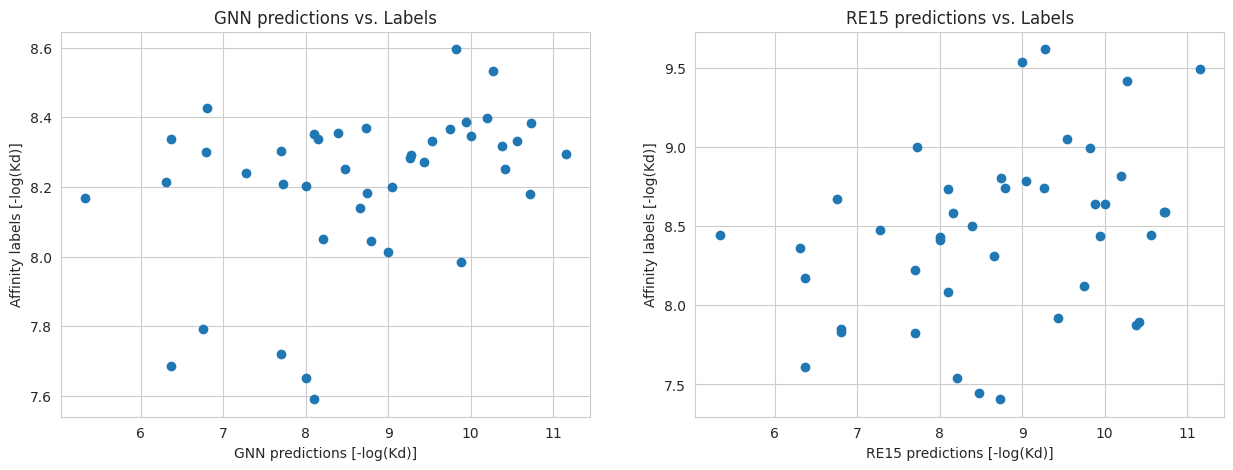

In [118]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].scatter(all_benchmark_labels, all_benchmark_gnn_predictions)
ax[0].set_title("GNN predictions vs. Labels")
ax[0].set_xlabel("GNN predictions [-log(Kd)]")
ax[0].set_ylabel("Affinity labels [-log(Kd)]")

ax[1].scatter(all_benchmark_labels, all_benchmark_ref15_predictions)
ax[1].set_title("RE15 predictions vs. Labels")
ax[1].set_xlabel("RE15 predictions [-log(Kd)]")
ax[1].set_ylabel("Affinity labels [-log(Kd)]")

plt.savefig(os.path.join(plot_path, "benchmark_preds_vs_labels.png"))
plt.show()
plt.close()

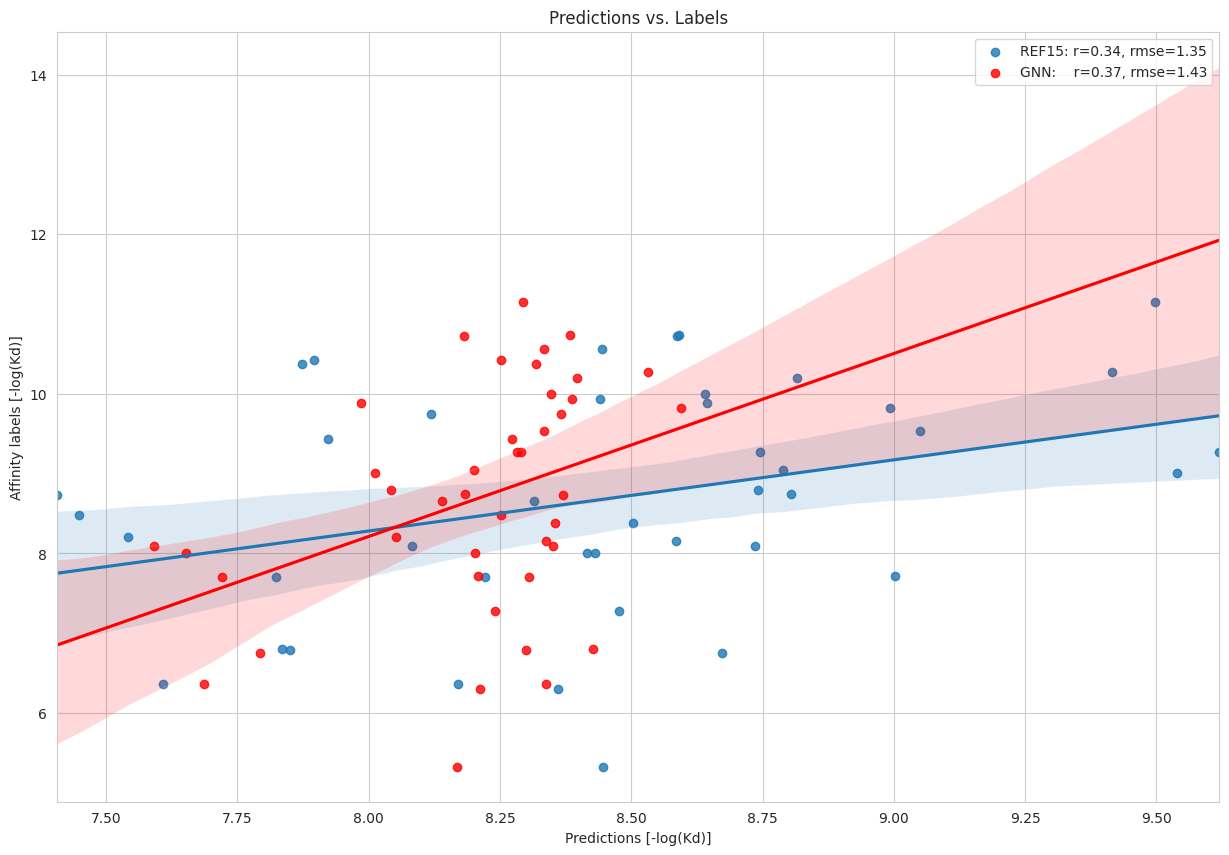

In [119]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

ax.set_xlim(np.min((all_benchmark_ref15_predictions.min(), all_benchmark_gnn_predictions.min())),
         np.max((all_benchmark_ref15_predictions.max(), all_benchmark_gnn_predictions.max())))


legend = "REF15: "
r, p = stats.pearsonr(x=all_benchmark_ref15_predictions.values, y=all_benchmark_labels)
legend += 'r={:.2f}, '.format(r)
error = np.sqrt(np.mean((all_benchmark_ref15_predictions.values-all_benchmark_labels)**2))
legend += 'rmse={:.2f}'.format(error)

sns.regplot( x=all_benchmark_ref15_predictions,y=all_benchmark_labels, ax=ax, truncate=False, label=legend)


legend = "GNN:    "
r, p = stats.pearsonr(x=all_benchmark_gnn_predictions, y=all_benchmark_labels.values)
legend += 'r={:.2f}, '.format(r)
error = np.sqrt(np.mean((all_benchmark_gnn_predictions.values-all_benchmark_labels)**2))
legend += 'rmse={:.2f}'.format(error)
sns.regplot(x=all_benchmark_gnn_predictions, y=all_benchmark_labels, ax=ax, color="red", truncate=False, label=legend)

ax.set_title("Predictions vs. Labels")
ax.set_xlabel("Predictions [-log(Kd)]")
ax.set_ylabel("Affinity labels [-log(Kd)]")

ax.legend()

plt.savefig(os.path.join(plot_path, "abag_full_comparison_scatter.png"))
plt.show()
plt.close()

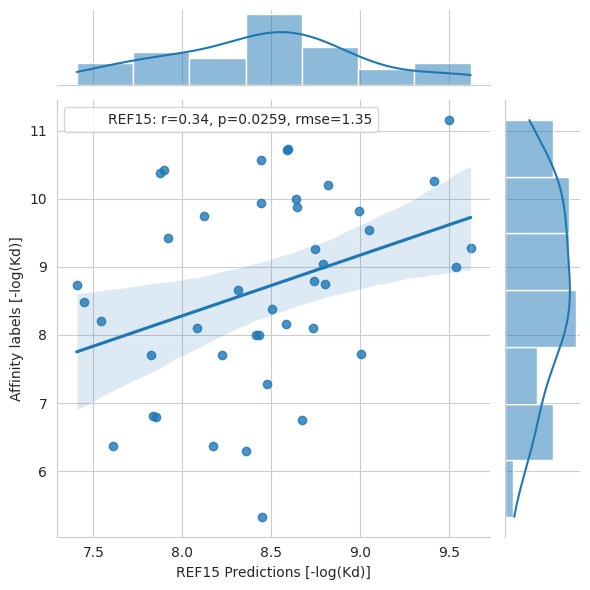

In [120]:
legend = "REF15: "
r, p = stats.pearsonr(x=all_benchmark_ref15_predictions, y=all_benchmark_labels)
legend += 'r={:.2f}, p={:.4f}, '.format(r, p)
error = np.sqrt(np.mean((all_benchmark_ref15_predictions-all_benchmark_labels)**2))
legend += 'rmse={:.2f}'.format(error)

plot = sns.jointplot(x=all_benchmark_ref15_predictions, y=all_benchmark_labels, kind="reg")

plot.ax_joint.set_xlabel("REF15 Predictions [-log(Kd)]")
plot.ax_joint.set_ylabel("Affinity labels [-log(Kd)]")

phantom, = plot.ax_joint.plot([], [], linestyle="", alpha=0)
plot.ax_joint.legend([phantom], [legend])
plt.tight_layout()

plt.savefig(os.path.join(plot_path, "ref15_behchmark_corr_plot.png"))
plt.show()
plt.close()

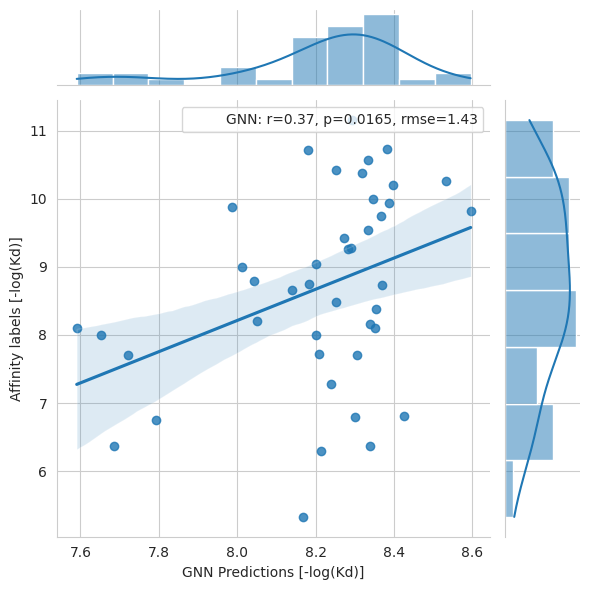

In [121]:
legend = "GNN: "
r, p = stats.pearsonr(x=all_benchmark_gnn_predictions, y=all_benchmark_labels)
legend += 'r={:.2f}, p={:.4f}, '.format(r, p)
error = np.sqrt(np.mean((all_benchmark_gnn_predictions-all_benchmark_labels)**2))
legend += 'rmse={:.2f}'.format(error)

plot = sns.jointplot(x=all_benchmark_gnn_predictions, y=all_benchmark_labels, kind="reg")

plot.ax_joint.set_xlabel("GNN Predictions [-log(Kd)]")
plot.ax_joint.set_ylabel("Affinity labels [-log(Kd)]")

phantom, = plot.ax_joint.plot([], [], linestyle="", alpha=0)
plot.ax_joint.legend([phantom], [legend])
plt.tight_layout()

plt.savefig(os.path.join(plot_path, "gnn_behchmark_corr_plot.png"))
plt.show()
plt.close()

In [122]:
stats.wilcoxon(np.abs(all_benchmark_ref15_predictions-all_benchmark_labels), np.abs(all_benchmark_gnn_predictions-all_benchmark_labels), alternative="less")

WilcoxonResult(statistic=366.0, pvalue=0.1425205853589815)

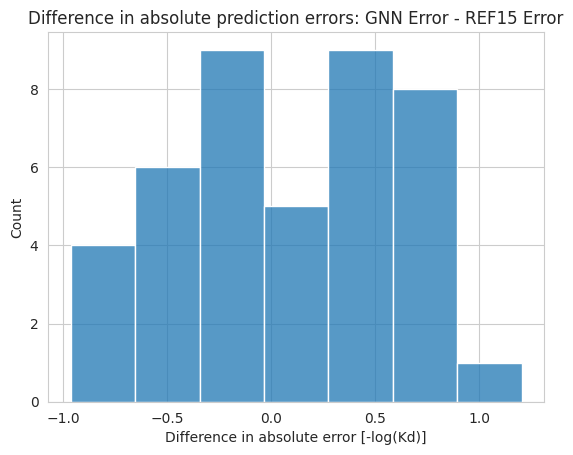

In [123]:
benchmark_error_diff = np.abs(all_benchmark_gnn_predictions-all_benchmark_labels) - np.abs(all_benchmark_ref15_predictions-all_benchmark_labels)
sns.histplot(benchmark_error_diff)

plt.title("Difference in absolute prediction errors: GNN Error - REF15 Error")
plt.xlabel("Difference in absolute error [-log(Kd)]")
plt.savefig(os.path.join(plot_path, "benchmark_error_difference_distributions.png"))
plt.show()
plt.close()